# Divvy Trip Analysis

Divvy is a bike rental service which has its own custom made bikes. A user can pickup a bike from one location and drop it to another location and only pay a small price for it. Learn more about them [here](https://www.divvybikes.com/how-it-works).

We are going to analyse the dataset given by divvy about its trips to see the differences between the 2 types of customers: **Casuals** and **Members**. We then try to recommend some steps in order to increase revenue and the number of members. 

Source: https://www.divvybikes.com/system-data <br>
Data Source: https://divvy-tripdata.s3.amazonaws.com/index.html <br>
License: https://www.divvybikes.com/data-license-agreement

### Index

1. [Import Libraries](#s1)
2. [Exploratory Analysis](#s2)<br>
    2.1 [Observations](#s21)<br>
    2.2 [Cleaning Steps Done](#s22)
3. [Data Transformation](#s3)
4. [Extracting Insights and Patterns](#s4)<br>
    4.1 [Observations](#s41)
5. [Conclusions and Recommendations](#s5)

---

<a id='s1'></a>

## Import Libraries

We first import all the required libraries

In [ ]:
#For calculating distance using latitude and longitude
!pip install haversine

In [62]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import haversine as hs

In [2]:
files = os.listdir()

files.remove(".DS_Store")
files.remove(".ipynb_checkpoints")
files.remove("Cyclist Analysis.ipynb")

In [3]:
df = pd.DataFrame()
for file in files:
    tempdf = pd.read_csv(file)
    df = df.append(tempdf,ignore_index=True)

---

<a id='s2'></a>

## Exploratory Analysis

We first check whether the dataset's columns are of the correct type and whether they have null values or not.

In [4]:
#Taking a look at first 5 rows of the dataset
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110,St. Clair St & Erie St,211,41.894177,-87.629127,41.894434,-87.623379,casual
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672,Noble St & Milwaukee Ave,29,41.890959,-87.635343,41.900675,-87.662480,casual
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76,Federal St & Polk St,41,41.880983,-87.616754,41.872054,-87.629550,casual
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659,Stave St & Armitage Ave,185,41.895499,-87.682013,41.917744,-87.691392,casual
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2,Buckingham Fountain,2,41.876497,-87.620358,41.876448,-87.620338,casual


In [5]:
#Overview of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4073561 entries, 0 to 4073560
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 404.0+ MB


In [17]:
#Checking number of duplicates in the dataset
len(df[df.duplicated()])

0

In [18]:
#Checking the percentage of missing values in each column
pd.DataFrame({"Missing values (%)": df.isnull().sum()/len(df.index)*100})

,Missing values (%)
ride_id,0.000000
rideable_type,0.000000
started_at,0.000000
ended_at,0.000000
start_station_name,4.958193
start_station_id,4.973560
end_station_name,5.626281
end_station_id,5.637598
start_lat,0.000000
start_lng,0.000000


In [24]:
#Checking if all rides have a unique ID
len(df["ride_id"].unique())

4073352

In [25]:
#Checking different types of 'rideable_type'
df["rideable_type"].unique()

array(['electric_bike', 'docked_bike', 'classic_bike'], dtype=object)

In [26]:
#Checking if unique 'start_station_id' maps to unique 'start_station_name'
pd.DataFrame({'Number of Start Station ID':[len(df["start_station_id"].unique())],
             'Number of Start Station Name':[len(df["start_station_name"].unique())]})

,Number of Start Station ID,Number of Start Station Name
0,1357,716


In [27]:
#Checking if unique 'end_station_id' maps to unique 'end_station_name'
pd.DataFrame({'Number of End Station ID':[len(df["end_station_id"].unique())],
             'Number of End Station Name':[len(df["end_station_name"].unique())]})

,Number of End Station ID,Number of End Station Name
0,1357,717


In [31]:
#Checking some general statistics for columns with numeric datatype
df.describe()

,start_lat,start_lng,end_lat,end_lng
count,4.073561e+06,4.073561e+06,4.068524e+06,4.068524e+06
mean,4.190331e+01,-8.764451e+01,4.190360e+01,-8.764479e+01
std,4.404066e-02,2.598052e-02,4.412742e-02,2.611267e-02
min,4.164000e+01,-8.787000e+01,4.154000e+01,-8.807000e+01
25%,4.188213e+01,-8.765875e+01,4.188224e+01,-8.765887e+01
50%,4.189964e+01,-8.764107e+01,4.190000e+01,-8.764129e+01
75%,4.192955e+01,-8.762759e+01,4.192958e+01,-8.762769e+01
max,4.208000e+01,-8.752000e+01,4.216000e+01,-8.744000e+01


In [28]:
#Checking the percentage of members/casuals
df["member_casual"].value_counts()/len(df.index)*100

member    57.939601
casual    42.060399
Name: member_casual, dtype: float64

<a id='s21'></a>

#### Obervations

* Columns `started_at, ended_at` need to converted into `datetime` format and `start_station_id, end_station_id` need to be converted into `int64` format.

* There are no duplicates in the dataset.

* There are missing values in `start_station_name, start_station_id, end_station_name, end_station_id, end_lat, end_lng`.

* Not all rides have a unique ID as the number of unique `ride_id` is not equal to the number of entries (and there are no missing values in that column).

* There are 3 types of bikes available.

* The number of `start_station_id` and `start_station_name` do not match. So there could be more than 1 station_id with the same station name or there is an error. The same goes for `end_station_id` and `end_station_name`.

Let's tackle some of the observations made

In [14]:
#Dropping records containing NaN values
df.dropna(inplace=True)

In [50]:
#Converting columns to appropriate datatypes
df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"] = pd.to_datetime(df["ended_at"])

In [7]:
df[df["ride_id"].duplicated()].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
599839,CDA12952E2FC2D99,docked_bike,2020-12-15 11:39:19,2020-11-25 10:16:59,Damen Ave & Thomas St (Augusta Blvd),TA1307000070,Morgan St & Polk St,TA1307000130,41.901315,-87.677409,41.871737,-87.651030,member
599998,934AEDB1B6C094EC,docked_bike,2020-12-15 11:46:37,2020-11-25 13:16:56,Throop St & Taylor St,13139,Halsted St & Polk St,TA1307000121,41.868968,-87.659141,41.871840,-87.646640,member
600369,F9338303AF8415BA,docked_bike,2020-12-15 12:12:41,2020-11-25 13:52:21,Burnham Harbor,15545,Indiana Ave & Roosevelt Rd,SL-005,41.856268,-87.613348,41.867888,-87.623041,member
600551,789640C9FEF98525,docked_bike,2020-12-15 11:47:48,2020-11-25 12:58:40,State St & 19th St,SL-013,Indiana Ave & Roosevelt Rd,SL-005,41.856594,-87.627542,41.867888,-87.623041,member
600566,52C655580214D2EF,docked_bike,2020-12-15 12:05:19,2020-11-25 19:03:00,Milwaukee Ave & Wabansia Ave,13243,Wood St & Chicago Ave,637,41.912616,-87.681391,41.895634,-87.672069,member


In [10]:
df[df["ride_id"]=="52C655580214D2EF"]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
79161,52C655580214D2EF,docked_bike,2020-11-25 18:48:50,2020-11-25 19:03:00,Milwaukee Ave & Wabansia Ave,158,Wood St & Chicago Ave,637,41.912616,-87.681391,41.895634,-87.672069,member
600566,52C655580214D2EF,docked_bike,2020-12-15 12:05:19,2020-11-25 19:03:00,Milwaukee Ave & Wabansia Ave,13243,Wood St & Chicago Ave,637,41.912616,-87.681391,41.895634,-87.672069,member


We see there are duplicates but they were earlier undetected because of different erroneous values for `start_station_id, end_station_id`. So we have to remove such rows.

In [17]:
df["ride_id"] = df["ride_id"].drop_duplicates()
df.dropna(inplace=True)

In [19]:
pd.DataFrame({"Missing values (%)": df.isnull().sum()/len(df.index)*100})

,Missing values (%)
ride_id,0.0
rideable_type,0.0
started_at,0.0
ended_at,0.0
start_station_name,0.0
start_station_id,0.0
end_station_name,0.0
end_station_id,0.0
start_lat,0.0
start_lng,0.0


In [38]:
#Including only those IDs which have a numeric value
df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]

In [39]:
#Converting columns to appropriate datatypes
df["start_station_id"] = df["start_station_id"].astype("float64")
df["end_station_id"] = df["end_station_id"].astype("float64")

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2834530 entries, 0 to 4073545
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    float64
 6   end_station_name    object 
 7   end_station_id      float64
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(6), object(7)
memory usage: 302.8+ MB


In [41]:
pd.DataFrame({'Number of Start Station ID':[len(df["start_station_id"].unique())],
             'Number of Start Station Name':[len(df["start_station_name"].unique())]})

,Number of Start Station ID,Number of Start Station Name
0,961,702


In [42]:
pd.DataFrame({'Number of End Station ID':[len(df["end_station_id"].unique())],
             'Number of End Station Name':[len(df["end_station_name"].unique())]})

,Number of End Station ID,Number of End Station Name
0,965,707


We see that the number of IDs is still greater than the number of names. Since there are no missing values, we can assume that some station names have more than one ID.

In [47]:
df.reset_index(drop=True,inplace=True)

<a id='s22'></a>

#### Cleaning Steps done

* Removed NaN values.
* Converted columns to apprpriate datatypes.
* Dropped duplicates from particular columns.

---

<a id='s3'></a>

## Data Transformation

Here we make new columns so that we can analyse the data in a better way.

In [51]:
#Adding column to find out ride duration in Hours:Minutes:Seconds
df["ride_duration"] = df["ended_at"] - df["started_at"]

In [ ]:
#Adding column to find distance covered in kilometers
dist_list = []
for i in range(len(df.index)):
    dist_list.append(hs.haversine((df["start_lat"][i],df["start_lng"][i]),(df["end_lat"][i],df["end_lng"][i])))
    #print(i,"/",len(df.index))


df["distance_covered"] = dist_list

In [56]:
#Adding column to find which day of the week did the ride start
df["day_of_week"] = df["started_at"].dt.dayofweek

#Monday -> 0
#Tuesday -> 1
#...

In [57]:
#Looking at our new formed table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834530 entries, 0 to 2834529
Data columns (total 16 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             object         
 1   rideable_type       object         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  object         
 5   start_station_id    float64        
 6   end_station_name    object         
 7   end_station_id      float64        
 8   start_lat           float64        
 9   start_lng           float64        
 10  end_lat             float64        
 11  end_lng             float64        
 12  member_casual       object         
 13  ride_duration       timedelta64[ns]
 14  distance_covered    float64        
 15  day_of_week         int64          
dtypes: datetime64[ns](2), float64(7), int64(1), object(5), timedelta64[ns](1)
memory usage: 346.0+ MB


Let's do some exploratory analysis on the new columns.

In [117]:
df[["ride_duration","distance_covered","day_of_week"]].describe()

,ride_duration,distance_covered,day_of_week
count,343005,342537.000000,343005.000000
mean,0 days 00:33:32.729001,2.296205,3.348068
std,0 days 04:07:24.085417,2.040378,2.008823
min,-1 days +23:55:57,0.000000,0.000000
25%,0 days 00:10:10,0.851062,2.000000
50%,0 days 00:18:09,1.831353,3.000000
75%,0 days 00:30:50,3.269988,5.000000
max,28 days 15:51:00,27.637099,6.000000


We see that for some ride durations, the time is in minus. That means for some records, the `started_at` was later than `ended_at`, which should not be the case and hence, we will delete such rows.

The other columns seem fine.

In [59]:
#Keeping only those rows which have time in positive
df = df[df["ride_duration"] > pd.to_timedelta("00:00:00")]

In [81]:
df.reset_index(drop=True,inplace=True)

---

<a id='s4'></a>

## Extracting Insights and Patterns

With the help of statistics and data visualizations, we try to find out hidden insights and patterns in the data.

In [138]:
ride_duration_list = [df["ride_duration"][i].total_seconds() for i in range(len(df.index))]

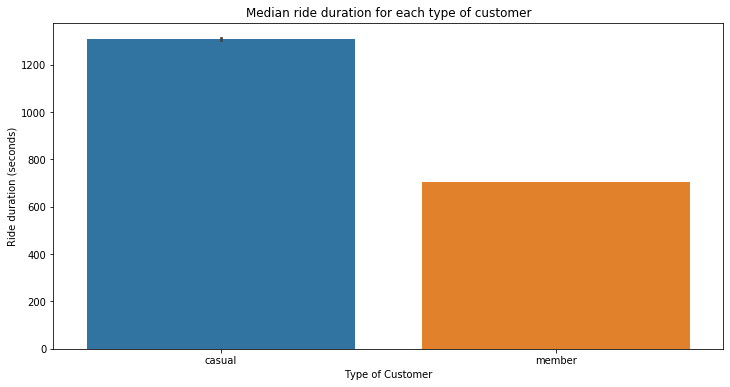

In [120]:
plt.figure(figsize=(12,6))
sns.barplot(data=pd.DataFrame({'ride_duration': ride_duration_list,
                              'member_casual': df["member_casual"]}), 
            x="member_casual", y="ride_duration",
            estimator=np.median)
plt.ylabel("Ride duration (seconds)")
plt.xlabel("Type of Customer")
plt.title("Median ride duration for each type of customer");

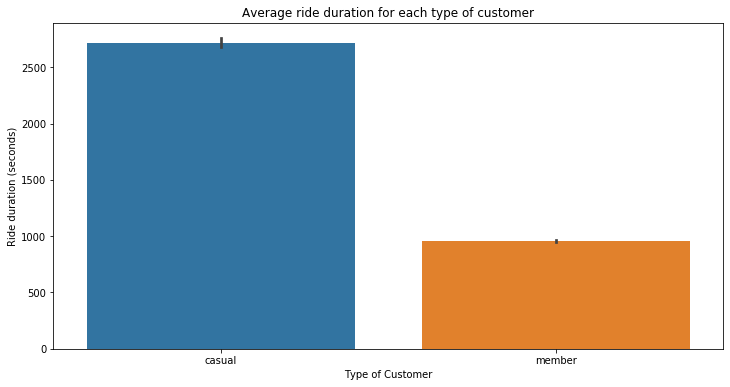

In [121]:
plt.figure(figsize=(12,6))
sns.barplot(data=pd.DataFrame({'ride_duration': ride_duration_list,
                              'member_casual':df["member_casual"]}), 
            x="member_casual", y="ride_duration")
plt.ylabel("Ride duration (seconds)")
plt.xlabel("Type of Customer")
plt.title("Average ride duration for each type of customer");

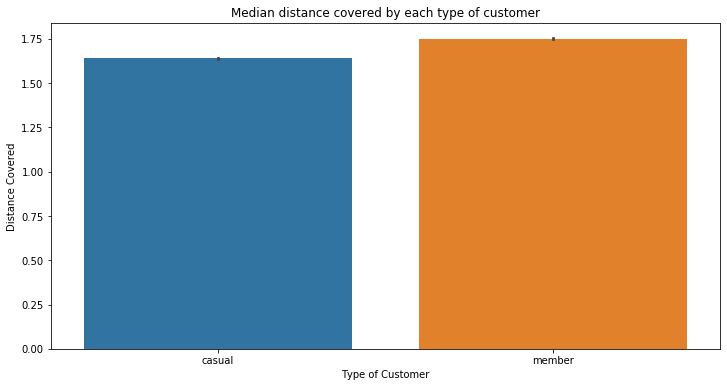

In [117]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="member_casual", y="distance_covered",estimator=np.median)
plt.ylabel("Distance Covered")
plt.xlabel("Type of Customer")
plt.title("Median distance covered by each type of customer");

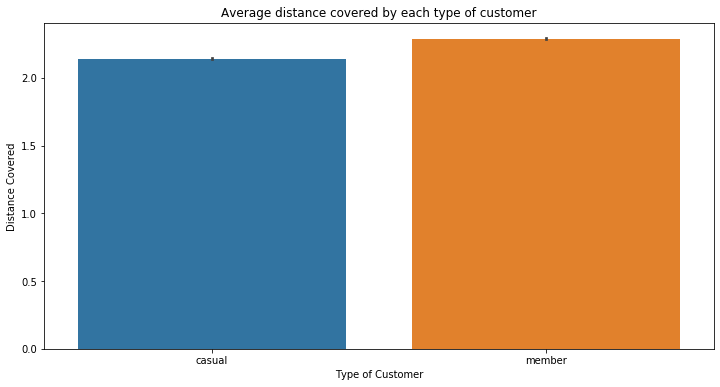

In [116]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="member_casual", y="distance_covered")
plt.ylabel("Distance Covered")
plt.xlabel("Type of Customer")
plt.title("Average distance covered by each type of customer");

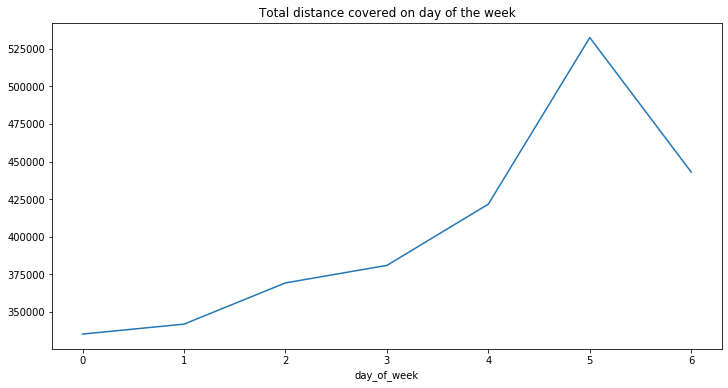

In [115]:
df.groupby(["day_of_week"]).count()["distance_covered"].plot(figsize=(12,6),
                                                             title="Total distance covered on day of the week");

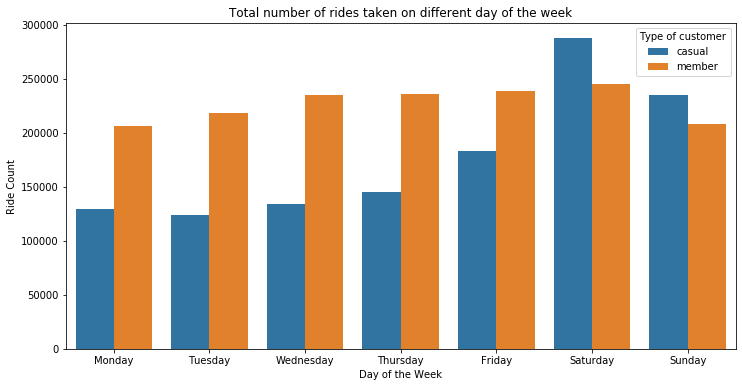

In [113]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(["day_of_week","member_casual"]).count()["distance_covered"].reset_index(), 
            x="day_of_week", y="distance_covered",hue="member_casual")
plt.legend(title="Type of customer")
plt.ylabel("Ride Count")
plt.xlabel("Day of the Week")
plt.xticks([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Total number of rides taken on different day of the week");

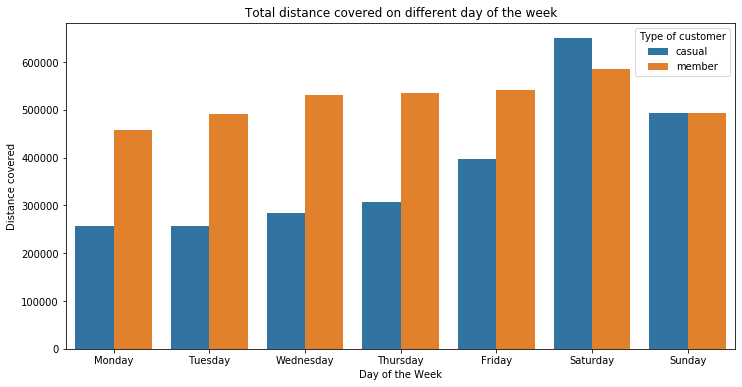

In [160]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(["day_of_week","member_casual"]).sum()["distance_covered"].reset_index(), 
            x="day_of_week", y="distance_covered",hue="member_casual")
plt.legend(title="Type of customer")
plt.ylabel("Distance covered")
plt.xlabel("Day of the Week")
plt.xticks([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Total distance covered on different day of the week");

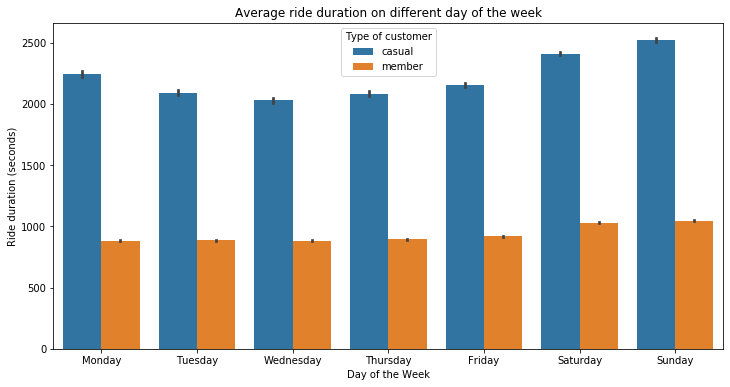

In [139]:
plt.figure(figsize=(12,6))
sns.barplot(data=pd.DataFrame({'ride_duration': ride_duration_list, 'day_of_week':df["day_of_week"],
                               'member_casual':df['member_casual']}), 
            x="day_of_week", y="ride_duration",hue="member_casual")
plt.legend(title="Type of customer")
plt.ylabel("Ride duration (seconds)")
plt.xlabel("Day of the Week")
plt.xticks([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Average ride duration on different day of the week");

In [226]:
df_stations = df.groupby(["start_station_name",
                          "end_station_name"]).count()["ride_id"].sort_values(ascending=False).reset_index()

df_stations.columns = ["start_station_name","end_station_name","rides"]

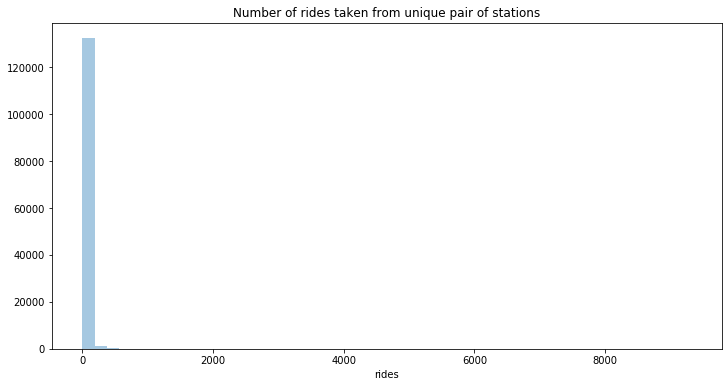

In [233]:
plt.figure(figsize=(12,6))
sns.distplot(df_stations["rides"],kde=False)
plt.title("Number of rides taken from unique pair of stations");

In [209]:
df_stations["rides"][0:8000].sum()/df_stations["rides"].sum()

0.5235508888410509

In [212]:
8000/len(df_stations.index)

0.059602303629035264

In [236]:
df.groupby(["rideable_type","member_casual"]).count().reset_index()

,rideable_type,member_casual,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,ride_duration,distance_covered,day_of_week
0,classic_bike,casual,66555,66555,66555,66555,66555,66555,66555,66555,66555,66555,66555,66555,66555,66555
1,classic_bike,member,114390,114390,114390,114390,114390,114390,114390,114390,114390,114390,114390,114390,114390,114390
2,docked_bike,casual,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097,1008097
3,docked_bike,member,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870,1251870
4,electric_bike,casual,162302,162302,162302,162302,162302,162302,162302,162302,162302,162302,162302,162302,162302,162302
5,electric_bike,member,221138,221138,221138,221138,221138,221138,221138,221138,221138,221138,221138,221138,221138,221138


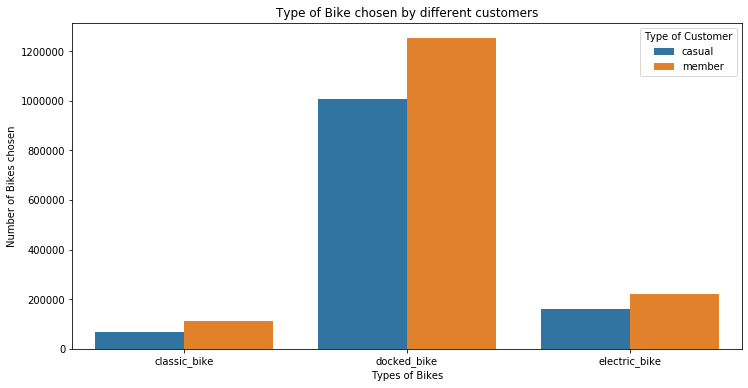

In [237]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(["rideable_type","member_casual"]).count().reset_index(),
            x="rideable_type",y="ride_id",hue="member_casual")
plt.legend(title="Type of Customer")
plt.ylabel("Number of Bikes chosen")
plt.xlabel("Types of Bikes")
plt.title("Type of Bike chosen by different customers");

<a id='s41'></a>

#### Obersations

* Casuals tend to have much **higher** ride durations than Members.
* Customers tend to cycle the **highest on Saturdays**.
* Members take a lot **more** rides on **weekdays** 
* Casuals take **more** rides on **weekends**.
* The **top 6%** of the stations contribute to **over 50%** of the rides taken.
* **Docked Bikes** are chosen the **most**, followed by Electric Bikes and then Classic Bikes.

---

<a id='s5'></a>

## Conclusions

* Casuals are probably office go-ers because they take less number of rides but ride longer distances.
* Majority of the Casuals ride only on the weekends.
* Members are consistent with their trips.
* Stations with the highest rides are situated in high populated areas or have a high number of bikes available.
* Docked Bikes are the favourites for all customers.

## Recommendations

* Incentives can be offered on weekends so that more Casuals join the membership.
* Station to station trip costs can be modified so that more revenue can be generated.